# PRE - PROCESSING

## Import functions

In [1]:
#pip install meteostat

In [2]:
#pip install --upgrade holidays

In [3]:
import holidays # For working with holiday data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import the necessary module
from sklearn.ensemble import GradientBoostingRegressor

from datetime import datetime
from meteostat import Stations, Daily # For working with weather data
from xgboost import plot_importance


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
## Features Functions

def create_datetime_features(df):
    """
    Creates time series features from datetime index
    Adapted from: https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost#Look-at-Worst-and-Best-Predicted-Days
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date'] = pd.to_datetime(df.index.date)
    return df

def get_holiday_features(df, country_code='US'):
    """
    Creates holiday features from datetime index
    """
    year_range = list(range(min(df.index.year), max(df.index.year) + 1))
    country_holidays = holidays.country_holidays(
        country_code,
        years=year_range,
        observed=False
    )
    holiday_df = pd.DataFrame(country_holidays.items())
    holiday_df.columns = ['date', 'holiday']
    holiday_df['date'] = pd.to_datetime(holiday_df['date'])
    return holiday_df

def get_weather_features(df, lat, lon):
    """
    Creates weather features based on latitude and longitude
    """
    room_temperature = 20  # Weather data is in Celsius
    start = min(df.index)
    end = max(df.index)

    stations = Stations()
    stations = stations.nearby(lat, lon)
    station = stations.fetch(1)

    # Get daily data
    weather_data = Daily(station['wmo'][0], start, end)
    weather_data = weather_data.fetch()
    weather_data = weather_data.dropna(axis=1)
    weather_data = weather_data.reset_index()
    weather_data['tmin_abs_diff_from_room_temperature'] = abs(weather_data['tmin'] - room_temperature)
    weather_data['tmax_abs_diff_from_room_temperature'] = abs(weather_data['tmax'] - room_temperature)
    weather_data = weather_data.rename(columns ={'time': 'date'})

    return weather_data

## Import data and feature engineering

In [5]:
main = 'https://raw.githubusercontent.com/Brunchcode/Forecasting-Energy-Consumption-Using-Machine-Learning/main/data/Timeseries/Timeseries_PJM_DOM_consumption_2006_to_2024.csv'

data_main = pd.read_csv(main,index_col=[0], parse_dates=[0])
data = create_datetime_features(data_main)
holiday_features = get_holiday_features(data)
weather_features = get_weather_features(data, 37.5407, -77.4360) # Richmond Capital of Virgina
data['datetime'] = data.index
data = data.merge(holiday_features, how='left', on='date')
data['holiday'] = data['holiday'].fillna('')
data = pd.get_dummies(data)
data = data.merge(weather_features, how='left', on='date')


remove_for_case_study = datetime(2020, 1, 1)
data_till_2019 = data.loc[data['datetime'] <= remove_for_case_study].copy()
case_study_data = data.loc[data['datetime'] > remove_for_case_study].copy()

In [6]:
data.head()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
0,9250.0,2006-01-01,0,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
1,8978.0,2006-01-01,1,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
2,8773.0,2006-01-01,2,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
3,8671.0,2006-01-01,3,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
4,8664.0,2006-01-01,4,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3


In [7]:
data.tail()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
162882,20498.376,2024-07-31,19,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162883,19814.648,2024-07-31,20,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162884,18910.259,2024-07-31,21,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162885,17645.255,2024-07-31,22,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162886,16421.592,2024-07-31,23,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2


In [8]:
data_till_2019.head()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
0,9250.0,2006-01-01,0,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
1,8978.0,2006-01-01,1,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
2,8773.0,2006-01-01,2,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
3,8671.0,2006-01-01,3,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
4,8664.0,2006-01-01,4,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3


In [9]:
data_till_2019.tail()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
122708,11442.870,2019-12-31,20,1,4,12,2019,365,31,1,...,False,False,False,10.9,5.0,13.9,0.0,11.9,15.0,6.1
122709,11166.770,2019-12-31,21,1,4,12,2019,365,31,1,...,False,False,False,10.9,5.0,13.9,0.0,11.9,15.0,6.1
122710,10838.550,2019-12-31,22,1,4,12,2019,365,31,1,...,False,False,False,10.9,5.0,13.9,0.0,11.9,15.0,6.1
122711,10592.674,2019-12-31,23,1,4,12,2019,365,31,1,...,False,False,False,10.9,5.0,13.9,0.0,11.9,15.0,6.1
122712,10364.707,2020-01-01,0,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8


In [10]:
case_study_data.head()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
122713,10291.858,2020-01-01,1,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122714,10252.082,2020-01-01,2,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122715,10303.804,2020-01-01,3,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122716,10588.920,2020-01-01,4,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122717,10980.540,2020-01-01,5,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8


In [11]:
case_study_data.tail()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
162882,20498.376,2024-07-31,19,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162883,19814.648,2024-07-31,20,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162884,18910.259,2024-07-31,21,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162885,17645.255,2024-07-31,22,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162886,16421.592,2024-07-31,23,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2


# old MODEL BUILDING

## Prediction with date time features (entire data)

In [18]:
split_date = datetime(2016, 1, 1)
train = data.loc[data['datetime'] <= split_date].copy()
test = data.loc[data['datetime'] > split_date].copy()
train_cols = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth']
X_train = train[train_cols]
y_train = train['energy_consumption_mw']
X_test = test[train_cols]
y_test = test['energy_consumption_mw']

gb_dt_reg = GradientBoostingRegressor()
gb_dt_reg.fit(X_train, y_train)
predictions = gb_dt_reg.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)*100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R^2: {gb_dt_reg.score(X_test, y_test)*100}")

RMSE: 2090.9440813386814
MAE: 1610.732158704201
MAPE: 12.731531726885315
R^2: 33.40826176482309


## Prediction with weather features and datetime (entire data)

In [19]:
split_date = datetime(2016, 1, 1)
train = data.loc[data['datetime'] <= split_date].copy()
test = data.loc[data['datetime'] > split_date].copy()
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

gb_all_reg = GradientBoostingRegressor()
gb_all_reg.fit(X_train, y_train)
predictions = gb_all_reg.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)*100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R^2: {gb_all_reg.score(X_test, y_test)*100}")

RMSE: 1714.7641683402771
MAE: 1329.4322133958206
MAPE: 10.51727068020507
R^2: 55.213789790194824


## Prediction with date time features (2006 - 2019)

In [20]:
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()
train_cols = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth']
X_train = train[train_cols]
y_train = train['energy_consumption_mw']
X_test = test[train_cols]
y_test = test['energy_consumption_mw']

gb_dt2019_reg = GradientBoostingRegressor()
gb_dt2019_reg.fit(X_train, y_train)
predictions = gb_dt2019_reg.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)*100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R^2: {gb_dt2019_reg.score(X_test, y_test)*100}")

RMSE: 1734.8043479131475
MAE: 1305.5876111483562
MAPE: 11.139567673337643
R^2: 49.67960145667587


## Prediction with weather features and datetime (2006 - 2019)

In [21]:
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

gb_all2019_reg = GradientBoostingRegressor()
gb_all2019_reg.fit(X_train, y_train)
predictions = gb_all2019_reg.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)*100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R^2: {gb_all2019_reg.score(X_test, y_test)*100}")

RMSE: 906.7920133611165
MAE: 694.4894282314251
MAPE: 5.943956287428924
R^2: 86.25140113443153


## Feature Importances

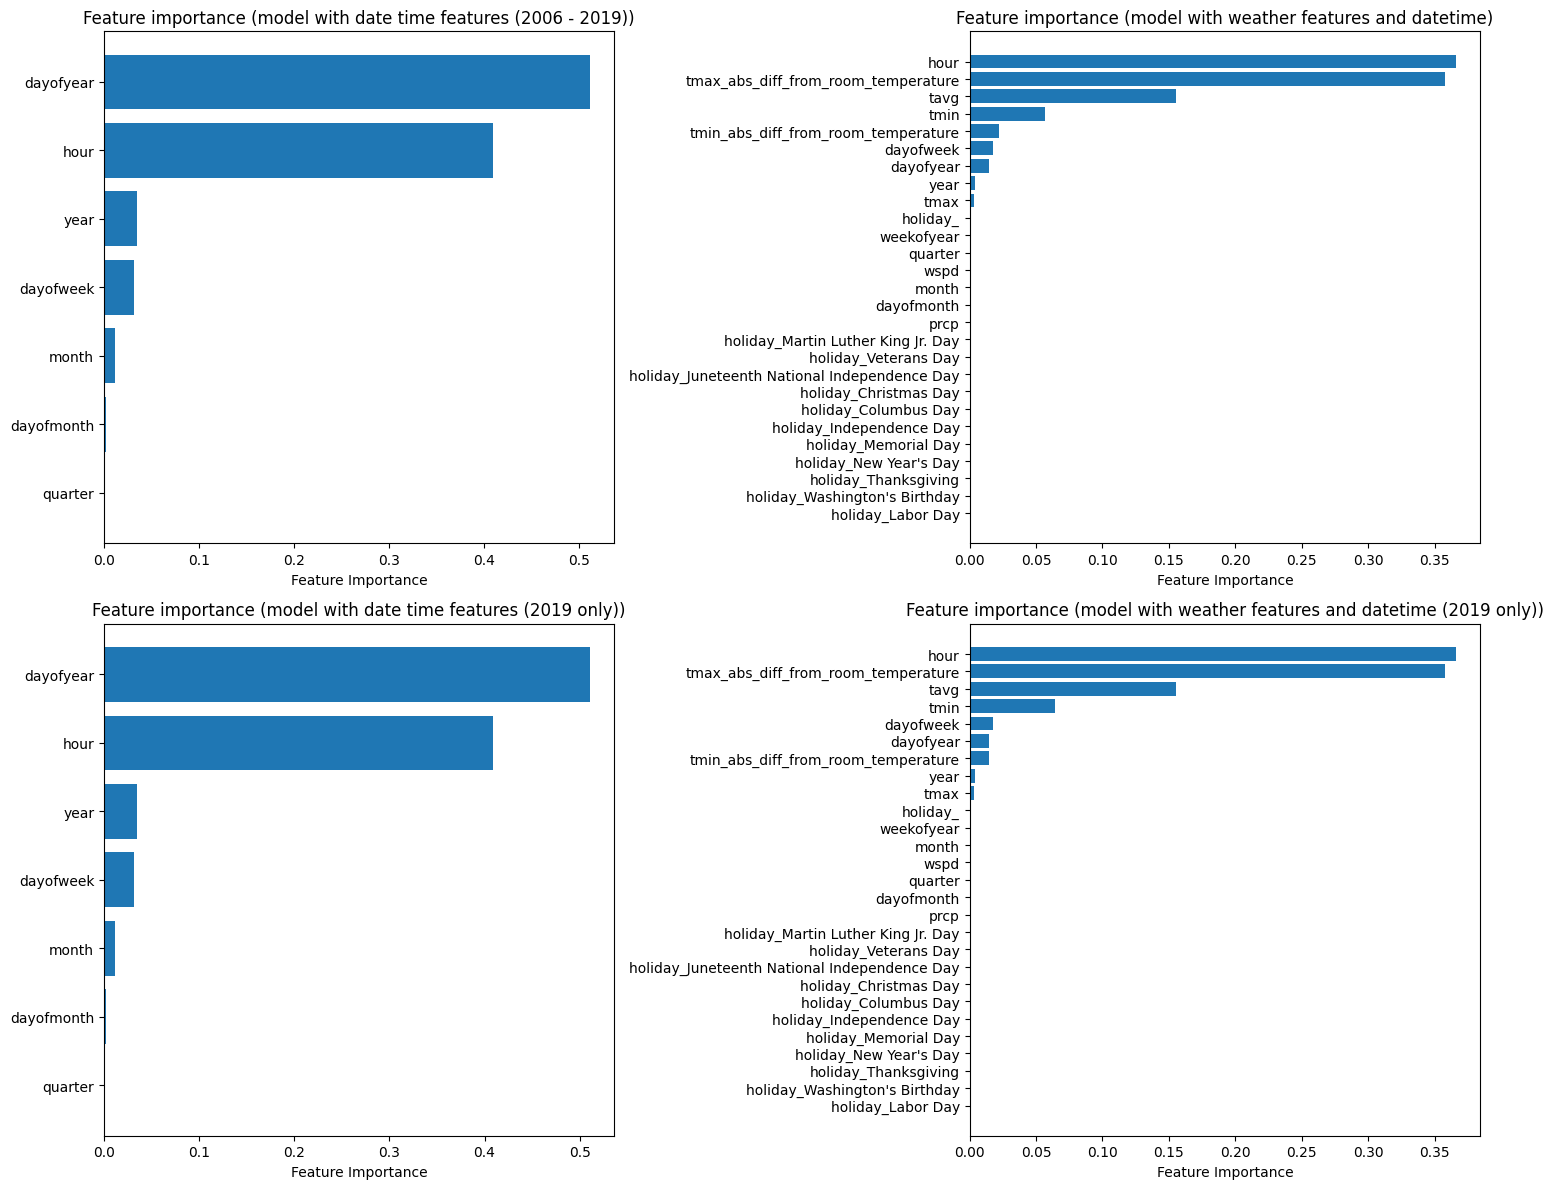

In [23]:
# Function to plot feature importance for a Gradient Boosting Regressor model with horizontal bars
def plot_gbr_importance(model, ax, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Sort by importance
    ax.barh(range(len(importances)), importances[indices], align="center")
    ax.set_yticks(range(len(importances)))
    ax.set_yticklabels(np.array(model.feature_names_in_)[indices])
    ax.set_title(title)
    ax.set_xlabel('Feature Importance')

# Create a figure and set up 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot feature importance for each Gradient Boosting Regressor model with horizontal bars
plot_gbr_importance(gb_dt_reg, axes[0, 0], 'Feature importance (model with date time features (2006 - 2019))')
plot_gbr_importance(gb_all_reg, axes[0, 1], 'Feature importance (model with weather features and datetime)')
plot_gbr_importance(gb_dt2019_reg, axes[1, 0], 'Feature importance (model with date time features (2019 only))')
plot_gbr_importance(gb_all2019_reg, axes[1, 1], 'Feature importance (model with weather features and datetime (2019 only))')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

## Retrain Model on case study

In [24]:
# Assuming Xgb_all2019_reg is already created and trained previously

# Splitting the data: training on 2020-2023, testing on 2024
split_date_train = datetime(2023, 7, 1)
train = case_study_data.loc[case_study_data['datetime'] < split_date_train].copy()  # Data from 2020 to end of 2023
test = case_study_data.loc[case_study_data['datetime'] >= split_date_train].copy()  # Data from 2024

# Dropping unnecessary columns for training and testing
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']  # Adjust 'date' column if necessary
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Retraining the existing Xgb_all2019_reg on the new data (2020-2023)
gb_all2019_reg.fit(X_train, y_train)

# Predictions on 2024 data
predictions = gb_all2019_reg.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100
r2 = gb_all2019_reg.score(X_test, y_test) * 100

# Print metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")  # Display MAPE as percentage with 2 decimal places
print(f"R^2: {r2:.2f}%")     # Display R^2 as percentage with 2 decimal places

RMSE: 1079.0313585236354
MAE: 825.8567303910237
MAPE: 5.62%
R^2: 81.18%


## Hyper parameter tunning

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import datetime

# Splitting the data as you did previously
split_date = datetime.datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Define a small grid of hyperparameters to search over for Gradient Boosting Regressor
param_grid = {
    'n_estimators': [50, 100, 150],         # Number of boosting stages to try
    'max_depth': [3, 5],               # Maximum depth of the individual trees
    'learning_rate': [0.05, 0.1],      # Learning rate shrinks the contribution of each tree
    'subsample': [0.8],                # Subsample ratio of the training instances
    'min_samples_split': [2, 5],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2]         # Minimum number of samples required to be at a leaf node
}

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor()

# Set up the GridSearchCV
gbr_grid_search = GridSearchCV(estimator=gbr,
                               param_grid=param_grid,
                               cv=3,  # 3-fold cross-validation
                               scoring='neg_mean_squared_error',  # Optimize for MSE
                               n_jobs=-1,  # Use all available cores
                               verbose=1)

# Fit grid search
gbr_grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = gbr_grid_search.best_params_
print("Best parameters found: ", best_params)

# Use the best estimator to make predictions
gbr_best_model = gbr_grid_search.best_estimator_
predictions = gbr_best_model.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100  # Convert to percentage
r2 = gbr_best_model.score(X_test, y_test) * 100  # Convert R^2 to percentage

# Print evaluation metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")
print(f"R^2: {r2:.2f}%")


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150, 'subsample': 0.8}
RMSE: 740.9259599303514
MAE: 585.4115793437751
MAPE: 5.12%
R^2: 90.82%


In [26]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import datetime

# Splitting the data as you did previously
split_date = datetime.datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Define a small grid of hyperparameters to search over for Gradient Boosting Regressor
param_grid = {
    'n_estimators': [50, 100, 150],         # Number of boosting stages to try
    'max_depth': [3, 5, 7],               # Maximum depth of the individual trees
    'learning_rate': [0.05, 0.1],      # Learning rate shrinks the contribution of each tree
    'subsample': [0.8, 1.0],                # Subsample ratio of the training instances
    'min_samples_split': [2, 5, 7],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3]         # Minimum number of samples required to be at a leaf node
}

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor()

# Set up the GridSearchCV
gbr_grid_search = GridSearchCV(estimator=gbr,
                               param_grid=param_grid,
                               cv=3,  # 3-fold cross-validation
                               scoring='neg_mean_squared_error',  # Optimize for MSE
                               n_jobs=-1,  # Use all available cores
                               verbose=1)

# Fit grid search
gbr_grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = gbr_grid_search.best_params_
print("Best parameters found: ", best_params)

# Use the best estimator to make predictions
gbr_best_model = gbr_grid_search.best_estimator_
predictions = gbr_best_model.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100  # Convert to percentage
r2 = gbr_best_model.score(X_test, y_test) * 100  # Convert R^2 to percentage

# Print evaluation metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")
print(f"R^2: {r2:.2f}%")

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 150, 'subsample': 0.8}
RMSE: 715.4623087750216
MAE: 564.2446236911221
MAPE: 4.91%
R^2: 91.44%


In [27]:
gbr_best_model

GradientBoostingRegressor(max_depth=7, min_samples_leaf=3, n_estimators=150,
                          subsample=0.8)

In [28]:
import joblib
# Save the best model to a file
joblib.dump(gbr_best_model, 'best_gradient_boosting_model.pkl')
print("Model saved successfully!")

Model saved successfully!


In [29]:
# Load the saved model
gbr_loaded_model = joblib.load('best_gradient_boosting_model.pkl')

# Use the loaded model for predictions
gbr_loaded_predictions = gbr_loaded_model.predict(X_test)

# Evaluate the loaded model
loaded_rmse = mean_squared_error(y_test, gbr_loaded_predictions, squared=False)
loaded_mae = mean_absolute_error(y_test, gbr_loaded_predictions)
loaded_mape = mean_absolute_percentage_error(y_test, gbr_loaded_predictions) * 100  # Convert to percentage
loaded_r2 = gbr_loaded_model.score(X_test, y_test) * 100  # Convert R^2 to percentage

print(f"Loaded Model RMSE: {loaded_rmse}")
print(f"Loaded Model MAE: {loaded_mae}")
print(f"Loaded Model MAPE: {loaded_mape:.2f}%")
print(f"Loaded Model R^2: {loaded_r2:.2f}%")

Loaded Model RMSE: 715.4623087750216
Loaded Model MAE: 564.2446236911221
Loaded Model MAPE: 4.91%
Loaded Model R^2: 91.44%


# Model Building 

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from joblib import dump, load
from datetime import datetime

# Step 0: Set the global random seed
np.random.seed(22)

# Step 1: Data Preprocessing and Normalization using Min-Max Scaling
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Train the Gradient Boosting Regressor model
gbr_all2019_reg = GradientBoostingRegressor(random_state=22)
gbr_all2019_reg.fit(X_train_scaled, y_train)

# Predictions
predictions = gbr_all2019_reg.predict(X_test_scaled)

# Step 3: Model Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print('Model Evaluation')
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"R^2: {gbr_all2019_reg.score(X_test_scaled, y_test) * 100:.2f}")

# Step 4: Save the trained model
dump(gbr_all2019_reg, 'saved models/GBR/gbr_all2019_reg_model.joblib')

# Step 5: Export actual vs. predictions to CSV for further analysis, with datetime as the index
test['Predicted'] = predictions
result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
result_df.columns = ['Actual', 'gbr_2019_Predicted']  # Rename columns for clarity
result_df.to_csv('saved models/GBR/gbr_all2019_reg_model_predictions_vs_actuals.csv')



Model Evaluation
RMSE: 906.8392402680763
MAE: 694.48550739075
MAPE: 5.94%
R^2: 86.25


In [13]:
# Case Study Example
split_date_train = datetime(2023, 7, 1)
train = case_study_data.loc[case_study_data['datetime'] < split_date_train].copy()
test = case_study_data.loc[case_study_data['datetime'] >= split_date_train].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the new training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 1: Load the previously saved model
loaded_model = load('saved models/GBR/gbr_all2019_reg_model.joblib')

# Step 2: Retrain the loaded model on 2020-2023 data
loaded_model.fit(X_train_scaled, y_train)

# Step 3: Make predictions on 2024 data
predictions = loaded_model.predict(X_test_scaled)

# Step 4: Evaluate the retrained model on the test set (2024 data)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100  # Convert to percentage
r2 = loaded_model.score(X_test_scaled, y_test) * 100  # Convert to percentage

# Print evaluation metrics
print('Evaluation for case study July 2023 to July 2024')
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")  # Display MAPE as percentage with 2 decimal places
print(f"R^2: {r2:.2f}%")     # Display R^2 as percentage with 2 decimal places

# Step 5: Save the retrained model
dump(loaded_model, 'saved models/GBR/gbr_all2020_2023_retrained_model.joblib')

# Step 6: Export actual vs. predictions for case study to CSV, with datetime as the index
test['Predicted'] = predictions
case_result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
case_result_df.columns = ['Actual', 'gbr_2023_Predicted']  # Rename columns for clarity
case_result_df.to_csv('saved models/GBR/gbr_all2020_2023_retrained_model_case_study_predictions_vs_actuals.csv')


Evaluation for case study July 2023 to July 2024
RMSE: 1077.6602578606526
MAE: 824.9357136757349
MAPE: 5.61%
R^2: 81.22%


# hyper parameter tunning

## hp 1

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
from datetime import datetime

# Step 0: Set the global random seed
np.random.seed(22)

# Step 1: Data Preprocessing and Normalization using Min-Max Scaling
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Define the hyperparameter grid for Gradient Boosting Regressor
param_grid = {
    'n_estimators': [50, 100, 150],          # Number of boosting stages
    'max_depth': [3, 5],                     # Maximum depth of individual trees
    'learning_rate': [0.05, 0.1],            # Learning rate for shrinking tree contributions
    'subsample': [0.8],                      # Subsample ratio of training instances
    'min_samples_split': [2, 5],             # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2]               # Minimum samples required at a leaf node
}

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=22)

# Step 3: Set up the GridSearchCV
gbr_grid_search = GridSearchCV(estimator=gbr,
                               param_grid=param_grid,
                               cv=3,  # Cross-validation folds
                               scoring='neg_mean_squared_error',  # Scoring based on negative MSE
                               n_jobs=-1,  # Use all available cores
                               verbose=1)

# Fit the grid search to the training data
gbr_grid_search.fit(X_train_scaled, y_train)

# Step 4: Get the best model from GridSearchCV
gbr_best_model = gbr_grid_search.best_estimator_

# Step 5: Make predictions with the best model
predictions = gbr_best_model.predict(X_test_scaled)

# Step 6: Model Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print('Model Evaluation')
print(f"Best Parameters: {gbr_grid_search.best_params_}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"R^2: {gbr_best_model.score(X_test_scaled, y_test) * 100:.2f}")

# Step 7: Save the best model from GridSearchCV
dump(gbr_best_model, 'saved models/GBR/gbr_best_model_grid_search.joblib')

# Step 8: Export actual vs. predictions to CSV for further analysis, with datetime as the index
test['Predicted'] = predictions
result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
result_df.columns = ['Actual', 'gbr_grid_search_predicted']  # Rename columns for clarity
result_df.to_csv('saved models/GBR/gbr_grid_search_predictions_vs_actuals.csv')



Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/brunchcode/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' 

Model Evaluation
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150, 'subsample': 0.8}
RMSE: 740.6007897975406
MAE: 583.5019368443171
MAPE: 5.09%
R^2: 90.83


In [15]:
# Case Study Example (2020-2023 training, 2024 testing)
split_date_train = datetime(2023, 7, 1)
train = case_study_data.loc[case_study_data['datetime'] < split_date_train].copy()
test = case_study_data.loc[case_study_data['datetime'] >= split_date_train].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the new training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 9: Load the best model from the previous training
loaded_model = load('saved models/GBR/gbr_best_model_grid_search.joblib')

# Step 10: Retrain the loaded model on 2020-2023 data
loaded_model.fit(X_train_scaled, y_train)

# Step 11: Make predictions on 2024 data
predictions = loaded_model.predict(X_test_scaled)

# Step 12: Evaluate the retrained model on the test set (2024 data)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100  # Convert to percentage
r2 = loaded_model.score(X_test_scaled, y_test) * 100  # Convert to percentage

# Print evaluation metrics
print('Evaluation for case study July 2023 to July 2024')
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")  # Display MAPE as percentage with 2 decimal places
print(f"R^2: {r2:.2f}%")     # Display R^2 as percentage with 2 decimal places

# Step 13: Save the retrained model
dump(loaded_model, 'saved models/GBR/gbr_2020_2023_retrained_grid_search_model.joblib')

# Step 14: Export actual vs. predictions for case study to CSV, with datetime as the index
test['Predicted'] = predictions
case_result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
case_result_df.columns = ['Actual', 'gbr_grid_search_2023_predicted']  # Rename columns for clarity
case_result_df.to_csv('saved models/GBR/gbr_grid_search_2023_predictions_vs_actuals.csv')


Evaluation for case study July 2023 to July 2024
RMSE: 906.2789367130929
MAE: 702.9148317053523
MAPE: 4.82%
R^2: 86.72%


## hp2

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
from datetime import datetime

# Step 0: Set the global random seed
np.random.seed(22)

# Step 1: Data Preprocessing and Normalization using Min-Max Scaling
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a small grid of hyperparameters to search over for Gradient Boosting Regressor
param_grid = {
    'n_estimators': [50, 100, 150],         # Number of boosting stages to try
    'max_depth': [3, 5, 7],               # Maximum depth of the individual trees
    'learning_rate': [0.05, 0.1],      # Learning rate shrinks the contribution of each tree
    'subsample': [0.8, 1.0],                # Subsample ratio of the training instances
    'min_samples_split': [2, 5, 7],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3]         # Minimum number of samples required to be at a leaf node
}

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=22)

# Step 3: Set up the GridSearchCV
gbr_grid_search = GridSearchCV(estimator=gbr,
                               param_grid=param_grid,
                               cv=3,  # Cross-validation folds
                               scoring='neg_mean_squared_error',  # Scoring based on negative MSE
                               n_jobs=-1,  # Use all available cores
                               verbose=1)

# Fit the grid search to the training data
gbr_grid_search.fit(X_train_scaled, y_train)

# Step 4: Get the best model from GridSearchCV
gbr_best_model2 = gbr_grid_search.best_estimator_

# Step 5: Make predictions with the best model
predictions = gbr_best_model2.predict(X_test_scaled)

# Step 6: Model Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print('Model Evaluation')
print(f"Best Parameters: {gbr_grid_search.best_params_}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"R^2: {gbr_best_model2.score(X_test_scaled, y_test) * 100:.2f}")

# Step 7: Save the best model from GridSearchCV
dump(gbr_best_model2, 'saved models/GBR/gbr_best_model_grid_search2.joblib')

# Step 8: Export actual vs. predictions to CSV for further analysis, with datetime as the index
test['Predicted'] = predictions
result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
result_df.columns = ['Actual', 'gbr_grid_search_predicted2']  # Rename columns for clarity
result_df.to_csv('saved models/GBR/gbr_grid_search_predictions_vs_actuals2.csv')



Fitting 3 folds for each of 324 candidates, totalling 972 fits
Model Evaluation
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150, 'subsample': 0.8}
RMSE: 718.4243585031267
MAE: 568.6528922120192
MAPE: 4.96%
R^2: 91.37


In [17]:
# Case Study Example (2020-2023 training, 2024 testing)
split_date_train = datetime(2023, 7, 1)
train = case_study_data.loc[case_study_data['datetime'] < split_date_train].copy()
test = case_study_data.loc[case_study_data['datetime'] >= split_date_train].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the new training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 9: Load the best model from the previous training
loaded_model = load('saved models/GBR/gbr_best_model_grid_search2.joblib')

# Step 10: Retrain the loaded model on 2020-2023 data
loaded_model.fit(X_train_scaled, y_train)

# Step 11: Make predictions on 2024 data
predictions = loaded_model.predict(X_test_scaled)

# Step 12: Evaluate the retrained model on the test set (2024 data)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100  # Convert to percentage
r2 = loaded_model.score(X_test_scaled, y_test) * 100  # Convert to percentage

# Print evaluation metrics
print('Evaluation for case study July 2023 to July 2024')
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")  # Display MAPE as percentage with 2 decimal places
print(f"R^2: {r2:.2f}%")     # Display R^2 as percentage with 2 decimal places

# Step 13: Save the retrained model
dump(loaded_model, 'saved models/GBR/gbr_2020_2023_retrained_grid_search_model2.joblib')

# Step 14: Export actual vs. predictions for case study to CSV, with datetime as the index
test['Predicted'] = predictions
case_result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
case_result_df.columns = ['Actual', 'gbr_grid_search_2023_predicted2']  # Rename columns for clarity
case_result_df.to_csv('saved models/GBR/gbr_grid_search_2023_predictions_vs_actuals2.csv')


Evaluation for case study July 2023 to July 2024
RMSE: 940.9567703955371
MAE: 732.5039532923986
MAPE: 5.01%
R^2: 85.68%
